### In this file we are making a conditional workdlow.

1. it will understand the sentiment
2. If positive then it will end with the reply message
3. If negetive then it will run the diagnosis and
4. Negetive feedback's reply message will be returned. 

In [46]:
from langgraph.graph import StateGraph, START, END
from langchain_groq import ChatGroq

from typing import TypedDict, Annotated, Literal
import operator
from dotenv import load_dotenv

from pydantic import BaseModel, Field

load_dotenv()

True

In [47]:
# Initialize Groq LLM
model = ChatGroq(model="llama-3.1-8b-instant")

In [48]:
## Creating Schemas for structural output from the models for two scenarios
class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'negetive'] = Field(description= "sentiment of the user review")

class DiagnosisSchema(BaseModel):
    issue_type: Literal['UX', 'performance', 'Bug', 'support', 'other'] = Field(description="The issue is mentioned in the review")
    tone: Literal['angry', 'frustrated', 'dissapointed', 'calm'] = Field(description="The emotional description of the user")
    urgency: Literal['high', 'medium', 'low'] = Field(description="How urgent the issue appear to be")

In [49]:
## Structural models
structural_model = model.with_structured_output(SentimentSchema)
structual_diagnosis_model = model.with_structured_output(DiagnosisSchema)

In [50]:
## Creating state
class ReviewState(TypedDict):
    review: str
    sentiment: Literal['positive', 'negetive']
    diagnosis: dict   ##As from the DiagnosisSchema we will get a structured output which will be a dictionary itself
    response: str

In [51]:
## node functions
def find_sentiment(state: ReviewState):
    prompt = f"find the sentiment of this user review {state['review']}"
    response = structural_model.invoke(prompt).sentiment
    return {'sentiment': response}

## To check the sentiment if it is positive or sentiment
def check_sentiment(state: ReviewState) -> Literal['positive_response', 'run_diagnosis']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'
    
## For positive response
def positive_response(state: ReviewState):
    prompt = f"Please leave a grateful message for the positive review - {state['review']}"
    response = model.invoke(prompt)

    return {'response': response}

## For negetive response
def run_diagnosis(state: ReviewState):
    prompt = f"Please analyze the user review and return the issue_type, tone and urgency - {state['review']}"
    response = structual_diagnosis_model.invoke(prompt)

    return {'diagnosis': response.model_dump()}  ## This will return the dictionary under the DiagnosisSchema

## For negetive response
def negetive_response(state: ReviewState):
    prompt = f"""You are a support assistant. The user had a {state['diagnosis']['issue_type']}\n, and marked urgency as {state['diagnosis']['urgency']}\n with a tone of {state['diagnosis']['tone']}"""
    response = model.invoke(prompt).content

    return {'response': response}

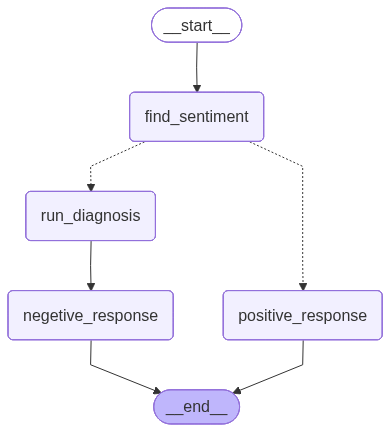

In [52]:
## Creating graph
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('negetive_response', negetive_response)
graph.add_node('run_diagnosis', run_diagnosis)

graph.add_edge(START, 'find_sentiment')
### Conditional edges 
graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negetive_response')
graph.add_edge('negetive_response', END)

workflow = graph.compile()
workflow

In [54]:
initital_state = {"review": 'I really do not understand why the form is not submitting!!'}

final_state = workflow.invoke(initital_state)

final_state
# print(f"Sentiment: {final_state.Sentiment}\n")
# print(f"Response: {final_state.response.content}\n")

      

{'review': 'I really do not understand why the form is not submitting!!',
 'sentiment': 'negetive',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "**Bug Report: High Urgency**\n\n**Details:**\n\n* **Bug Type:** [Insert bug type, e.g., UI issue, functionality error, etc.]\n* **Description:** [Insert a detailed description of the issue]\n* **Steps to Reproduce:** [Insert step-by-step instructions to reproduce the issue]\n* **Expected Result:** [Insert the expected outcome]\n* **Actual Result:** [Insert the actual outcome]\n\n**User Feedback:**\n\n* **Urgency Level:** High\n* **Tone:** Frustrated\n\n**Summary:**\n\nI understand that you're experiencing a critical issue with [insert bug type]. I'll do my best to assist you promptly and resolve this issue as soon as possible.\n\nTo better assist you, could you please provide more information about the issue, including any relevant screenshots or error messages? Additionally, are there any workaro